In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

Code severely inspired by lectures

In [2]:
paths = [
    "./datasets/angry",
    "./datasets/fear",
    "./datasets/happy",
    "./datasets/sad"
]

training_df = pd.DataFrame(columns=['loudness', 'mfccs', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'])
testing_df = pd.DataFrame(columns=['loudness', 'mfccs', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'])

def dictionary_mean(d):
    return sum(d.values()) / len(d)



Feature Extraction Functions:

In [3]:
def feature_extraction_loudness(signal):
    '''

    :param signal: amplitude of the audio at a specific point in time
    :return: mean loudness of the audio
    '''
    df_loudness = pd.DataFrame()
    # separates spectrogram into magnitude and phase
    S, phase = librosa.magphase(librosa.stft(signal))
    # Takes the Root Mean Square of the magnitude
    rms = librosa.feature.rms(S=S)
    df_loudness['Loudness'] = rms[0]
    return df_loudness['Loudness'].mean()


def feature_extraction_mfccs(signal, sample_rate):
    '''
    Analyzes power spectrum of the signal in the frequency domain

    :param signal: amplitude of the audio at a specific point in time
    :param sample_rate: number of samples per second in the audio
    :return: dictionary where the (key, value) pair is (MFCC_X, mean value of df_mfccs col)
    '''
    df_mfccs = pd.DataFrame()
    avgs = {}

    # calculates the MFCC features for the signal
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12)

    # creates the dataframe of all the mfccs from 1 to 12
    for n_mfcc in range(len(mfccs)):
        df_mfccs['MFCC_%d' % (n_mfcc + 1)] = mfccs.T[n_mfcc]

    # gets averages
    for col, vals in df_mfccs.iteritems():
        avgs[col] = vals.mean()

    return avgs


def feature_extraction_ZCR(signal):
    '''
    Measures the rate of at which the signal changes sign over time

    :param signal: amplitude of the audio at a specific point in time
    :return: mean of the zero crossing rate
    '''
    df_zero_crossing_rate = pd.DataFrame()
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    df_zero_crossing_rate['ZCR'] = zcr[0]
    return df_zero_crossing_rate['ZCR'].mean()


def feature_extraction_chroma(signal, sample_rate):
    '''
    Captures distribution of pitch classes.

    :param signal: amplitude of the audio at a specific point in time
    :param sample_rate: number of samples per second in the audio
    :return: dictionary where the (key, value) pair is (Chroma_X, mean value of df_chroma col)
    '''
    df_chroma = pd.DataFrame()
    avgs = {}
    # computes the chromagram using short-time Fourier transform that
    # provides a time-frequency representation of the signal
    chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
    for n_chroma in range(len(chromagram)):
        df_chroma['Chroma_%d' % (n_chroma + 1)] = chromagram.T[n_chroma]

    # gets averages
    for col, vals in df_chroma.iteritems():
        avgs[col] = vals.mean()

    return avgs


def feature_extraction_mel_spectrogram(signal, sample_rate):
    '''
    Represents the frequency content of a signal using the mel frequency scale

    :param signal: amplitude of the audio at a specific point in time
    :param sample_rate: number of samples per second in the audio
    :return: dictionary where the (key, value) pair is (Mel_Spectrogram__X, mean value of df_mel_spectrogram col)
    '''
    df_mel_spectrogram = pd.DataFrame()
    avgs = {}
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12)
    for n_mel in range(len(mel_spectrogram)):
        df_mel_spectrogram['Mel_Spectrogram_%d' % (n_mel + 1)] = mel_spectrogram.T[n_mel]

    # gets averages
    for col, vals in df_mel_spectrogram.iteritems():
        avgs[col] = vals.mean()

    return avgs

Loads data and splits it into training and testing

In [4]:
def load_all(folders, training_df, testing_df):
    result = []
    for i in range(4):
        files = os.listdir(paths[i])
        random.shuffle(files)
        emotion = "angry"
        if i == 0:
            pass
        elif i == 1:
            emotion = "fear"
        elif i == 2:
            emotion = "happy"
        elif i == 3:
            emotion = "sad"
        else:
            raise Exception("something doesnt work")

        for idx, file in enumerate(files):
            signal, sample_rate = librosa.load(f'./datasets/{emotion}/{file}')
            loudness = feature_extraction_loudness(signal)
            mfccs = dictionary_mean(feature_extraction_mfccs(signal, sample_rate))
            zcr = feature_extraction_ZCR(signal)
            chroma = dictionary_mean(feature_extraction_chroma(signal, sample_rate))
            mel_spectrogram = dictionary_mean(feature_extraction_mel_spectrogram(signal, sample_rate))

            new_row = {'loudness': loudness, 'mfccs': mfccs, 'zcr': zcr, 'chroma': chroma,
                       'mel_spectrogram': mel_spectrogram, 'emotion': emotion}
            if idx < 70:
                training_df = training_df.append(new_row, ignore_index=True)
            else:
                testing_df = testing_df.append(new_row, ignore_index=True)



    return training_df, testing_df


In [5]:
def time_domain_plot(sample):
    # signal is the amplitude of the audio at a specific point in time
    # sample_rate is the number of samples per second in the audio file
    signal, sample_rate = librosa.load(sample)
    plt.figure(1)
    librosa.display.waveshow(y=signal, sr=sample_rate)
    plt.xlabel('Time / second')
    plt.ylabel('Amplitude')
    plt.show()


def freq_domain_plot(sample):
    signal, sample_rate = librosa.load(sample)
    # k creates an array with values between 0 and the length of signal increasing by 1
    # T calculates the duration of the audio signal
    k = np.arange(len(signal))
    T = len(signal) / sample_rate
    freq = k / T

    DATA_0 = np.fft.fft(signal)
    abs_DATA_0 = abs(DATA_0)
    plt.figure(2)
    plt.plot(freq, abs_DATA_0)
    plt.xlabel("Frequency / Hz")
    plt.ylabel("Amplitude / dB")
    plt.xlim([0, 1000])
    plt.show()

Some Exploratory Data Analysis

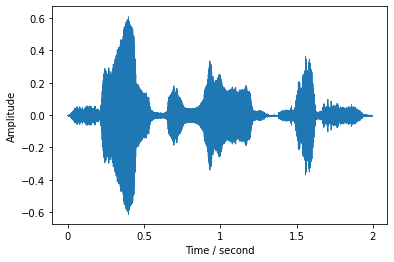

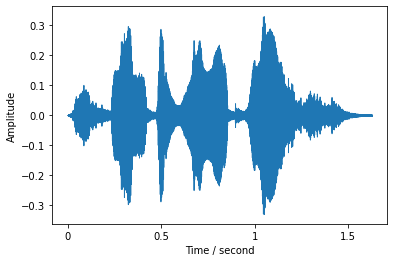

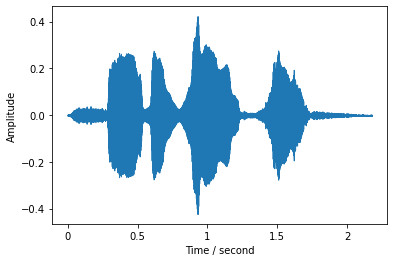

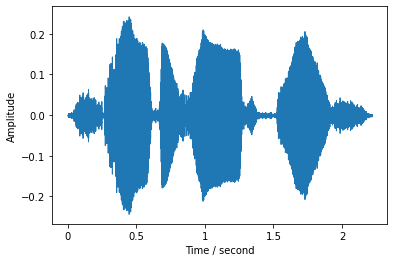

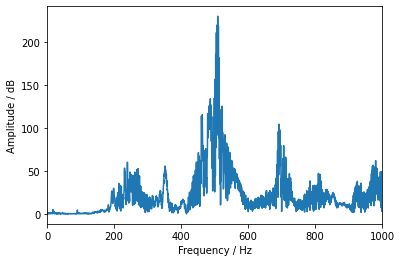

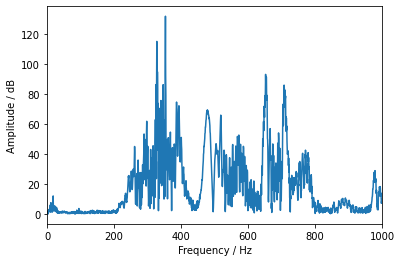

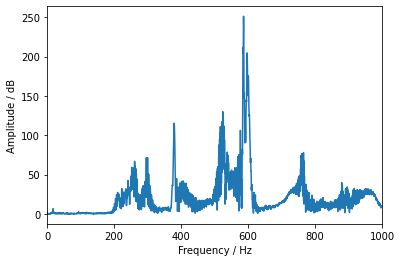

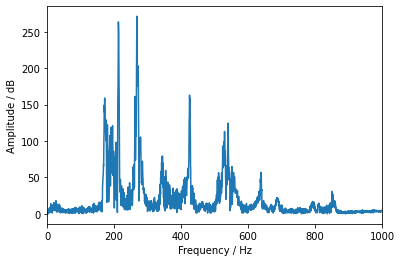

In [6]:
time_domain_plot('./datasets/angry/YAF_yes_angry.wav')
time_domain_plot('./datasets/fear/YAF_yes_fear.wav')
time_domain_plot('./datasets/happy/YAF_yes_happy.wav')
time_domain_plot('./datasets/sad/YAF_yes_sad.wav')

freq_domain_plot('./datasets/angry/YAF_yes_angry.wav')
freq_domain_plot('./datasets/fear/YAF_yes_fear.wav')
freq_domain_plot('./datasets/happy/YAF_yes_happy.wav')
freq_domain_plot('./datasets/sad/YAF_yes_sad.wav')

In [7]:
training_df, testing_df = load_all(paths, training_df, testing_df)
training_df.to_csv('training_df.csv', index=False)
testing_df.to_csv('testing_df.csv', index=False)

In [8]:
x_train = training_df.drop('emotion', axis=1)
y_train = training_df['emotion']

x_test = testing_df.drop('emotion', axis=1)
y_test = testing_df['emotion']

Support Vector Machines:

In [9]:

scaler = StandardScaler()
print("Support Vector Machines:")
print("------------------------")

print("Just loudness:")
x_train_loudness = training_df.drop(['mfccs', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)
x_test_loudness = testing_df.drop(['mfccs', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)

x_train_scaled = scaler.fit_transform(x_train_loudness)
x_test_scaled = scaler.transform(x_test_loudness)

svc = SVC(probability=True)
svc.fit(x_train_scaled, y_train)

y_svc_predicted = svc.predict(x_test_scaled)
print(classification_report(y_test, y_svc_predicted, zero_division=0))

print("Just mfccs:")
x_train_mfccs = training_df.drop(['loudness', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)
x_test_mfccs = testing_df.drop(['loudness', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)

x_train_scaled = scaler.fit_transform(x_train_mfccs)
x_test_scaled = scaler.transform(x_test_mfccs)

svc = SVC(probability=True)
svc.fit(x_train_scaled, y_train)

y_svc_predicted = svc.predict(x_test_scaled)
print(classification_report(y_test, y_svc_predicted, zero_division=0))

print("Just zcr:")
x_train_zcr = training_df.drop(['loudness', 'mfccs', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)
x_test_zcr = testing_df.drop(['loudness', 'mfccs', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)

x_train_scaled = scaler.fit_transform(x_train_zcr)
x_test_scaled = scaler.transform(x_test_zcr)

svc = SVC(probability=True)
svc.fit(x_train_scaled, y_train)

y_svc_predicted = svc.predict(x_test_scaled)
print(classification_report(y_test, y_svc_predicted, zero_division=0))

print("Just chroma:")
x_train_chroma = training_df.drop(['loudness', 'mfccs', 'zcr', 'mel_spectrogram', 'emotion'], axis=1)
x_test_chroma = testing_df.drop(['loudness', 'mfccs', 'zcr', 'mel_spectrogram', 'emotion'], axis=1)

x_train_scaled = scaler.fit_transform(x_train_chroma)
x_test_scaled = scaler.transform(x_test_chroma)

svc = SVC(probability=True)
svc.fit(x_train_scaled, y_train)

y_svc_predicted = svc.predict(x_test_scaled)
print(classification_report(y_test, y_svc_predicted, zero_division=0))

print("Just mel_spectrogram:")
x_train_mel_spectrogram = training_df.drop(['loudness', 'mfccs', 'zcr', 'chroma', 'emotion'], axis=1)
x_test_mel_spectrogram = testing_df.drop(['loudness', 'mfccs', 'zcr', 'chroma', 'emotion'], axis=1)

x_train_scaled = scaler.fit_transform(x_train_mel_spectrogram)
x_test_scaled = scaler.transform(x_test_mel_spectrogram)

svc = SVC(probability=True)
svc.fit(x_train_scaled, y_train)

y_svc_predicted = svc.predict(x_test_scaled)
print(classification_report(y_test, y_svc_predicted, zero_division=0))

print("Just loudness and mel_spectrogram:")
x_train_1 = training_df.drop(['mfccs', 'zcr', 'chroma', 'emotion'], axis=1)
x_test_1 = testing_df.drop(['mfccs', 'zcr', 'chroma', 'emotion'], axis=1)

x_train_scaled = scaler.fit_transform(x_train_1)
x_test_scaled = scaler.transform(x_test_1)


svc = SVC(probability=True)
svc.fit(x_train_scaled, y_train)

y_svc_predicted = svc.predict(x_test_scaled)
print(classification_report(y_test, y_svc_predicted, zero_division=0))

print("Just mfccs, zcr, and chroma:")
x_train_2 = training_df.drop(['loudness', 'mel_spectrogram', 'emotion'], axis=1)
x_test_2 = testing_df.drop(['loudness', 'mel_spectrogram', 'emotion'], axis=1)

x_train_scaled = scaler.fit_transform(x_train_2)
x_test_scaled = scaler.transform(x_test_2)


svc = SVC(probability=True)
svc.fit(x_train_scaled, y_train)

y_svc_predicted = svc.predict(x_test_scaled)
print(classification_report(y_test, y_svc_predicted, zero_division=0))



print("All features:")

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

svc = SVC(probability=True)
svc.fit(x_train_scaled, y_train)

y_svc_predicted = svc.predict(x_test_scaled)
print(classification_report(y_test, y_svc_predicted, zero_division=0))


Support Vector Machines:
------------------------
Just loudness:
              precision    recall  f1-score   support

       angry       0.41      0.77      0.53        30
        fear       0.00      0.00      0.00        30
       happy       0.79      0.77      0.78        30
         sad       0.74      0.87      0.80        30

    accuracy                           0.60       120
   macro avg       0.49      0.60      0.53       120
weighted avg       0.49      0.60      0.53       120

Just mfccs:
              precision    recall  f1-score   support

       angry       0.73      0.90      0.81        30
        fear       0.44      0.60      0.51        30
       happy       0.38      0.47      0.42        30
         sad       0.60      0.10      0.17        30

    accuracy                           0.52       120
   macro avg       0.54      0.52      0.48       120
weighted avg       0.54      0.52      0.48       120

Just zcr:
              precision    recall  f1-score

Random Forest Classifier

In [12]:
print("Random Forest:")
print("--------------")

print("Just loudness:")
x_train_loudness = training_df.drop(['mfccs', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)
x_test_loudness = testing_df.drop(['mfccs', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)

rfc = RandomForestClassifier()
rfc.fit(x_train_loudness, y_train)

y_rfc_predicted = rfc.predict(x_test_loudness)
print(classification_report(y_test, y_rfc_predicted, zero_division=0))

print("Just mfccs:")
x_train_mfccs = training_df.drop(['loudness', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)
x_test_mfccs = testing_df.drop(['loudness', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)

rfc = RandomForestClassifier()
rfc.fit(x_train_mfccs, y_train)

y_rfc_predicted = rfc.predict(x_test_mfccs)
print(classification_report(y_test, y_rfc_predicted, zero_division=0))

print("Just zcr:")
x_train_zcr = training_df.drop(['loudness', 'mfccs', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)
x_test_zcr = testing_df.drop(['loudness', 'mfccs', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)

rfc = RandomForestClassifier()
rfc.fit(x_train_zcr, y_train)

y_rfc_predicted = rfc.predict(x_test_zcr)
print(classification_report(y_test, y_rfc_predicted, zero_division=0))

print("Just chroma:")
x_train_chroma = training_df.drop(['loudness', 'mfccs', 'zcr', 'mel_spectrogram', 'emotion'], axis=1)
x_test_chroma = testing_df.drop(['loudness', 'mfccs', 'zcr', 'mel_spectrogram', 'emotion'], axis=1)

rfc = RandomForestClassifier()
rfc.fit(x_train_chroma, y_train)

y_rfc_predicted = rfc.predict(x_test_chroma)
print(classification_report(y_test, y_rfc_predicted, zero_division=0))

print("Just mel_spectrogram:")
x_train_mel_spectrogram = training_df.drop(['loudness', 'mfccs', 'zcr', 'chroma', 'emotion'], axis=1)
x_test_mel_spectrogram = testing_df.drop(['loudness', 'mfccs', 'zcr', 'chroma', 'emotion'], axis=1)

rfc = RandomForestClassifier()
rfc.fit(x_train_mel_spectrogram, y_train)

y_rfc_predicted = rfc.predict(x_test_mel_spectrogram)
print(classification_report(y_test, y_rfc_predicted, zero_division=0))

print("Just loudness and mel_spectrogram:")
x_train_1 = training_df.drop(['mfccs', 'zcr', 'chroma', 'emotion'], axis=1)
x_test_1 = testing_df.drop(['mfccs', 'zcr', 'chroma', 'emotion'], axis=1)

rfc = RandomForestClassifier()
rfc.fit(x_train_1, y_train)

y_rfc_predicted = rfc.predict(x_test_1)
print(classification_report(y_test, y_rfc_predicted, zero_division=0))

print("Just mfccs, zcr, and chroma:")
x_train_2 = training_df.drop(['loudness', 'mel_spectrogram', 'emotion'], axis=1)
x_test_2 = testing_df.drop(['loudness', 'mel_spectrogram', 'emotion'], axis=1)

rfc = RandomForestClassifier()
rfc.fit(x_train_2, y_train)

y_rfc_predicted = rfc.predict(x_test_2)
print(classification_report(y_test, y_rfc_predicted, zero_division=0))

print("All features:")
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

y_rfc_predicted = rfc.predict(x_test)
y_rfc_pred_proba = rfc.predict_proba(x_test)
print(classification_report(y_test, y_rfc_predicted, zero_division=0))

Random Forest:
--------------
Just loudness:
              precision    recall  f1-score   support

       angry       0.39      0.37      0.38        30
        fear       0.41      0.43      0.42        30
       happy       0.62      0.50      0.56        30
         sad       0.61      0.73      0.67        30

    accuracy                           0.51       120
   macro avg       0.51      0.51      0.51       120
weighted avg       0.51      0.51      0.51       120

Just mfccs:
              precision    recall  f1-score   support

       angry       0.64      0.70      0.67        30
        fear       0.41      0.37      0.39        30
       happy       0.56      0.50      0.53        30
         sad       0.27      0.30      0.29        30

    accuracy                           0.47       120
   macro avg       0.47      0.47      0.47       120
weighted avg       0.47      0.47      0.47       120

Just zcr:
              precision    recall  f1-score   support

       a

Naive Bayes

In [13]:
print("Naive Bayes:")
print("--------------")

print("Just loudness:")
x_train_loudness = training_df.drop(['mfccs', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)
x_test_loudness = testing_df.drop(['mfccs', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)

nbc = GaussianNB()
nbc.fit(x_train_loudness, y_train)

y_nbc_predicted = nbc.predict(x_test_loudness)
print(classification_report(y_test, y_nbc_predicted, zero_division=0))

print("Just mfccs:")
x_train_mfccs = training_df.drop(['loudness', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)
x_test_mfccs = testing_df.drop(['loudness', 'zcr', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)

nbc = GaussianNB()
nbc.fit(x_train_mfccs, y_train)

y_nbc_predicted = nbc.predict(x_test_mfccs)
print(classification_report(y_test, y_nbc_predicted, zero_division=0))

print("Just zcr:")
x_train_zcr = training_df.drop(['loudness', 'mfccs', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)
x_test_zcr = testing_df.drop(['loudness', 'mfccs', 'chroma', 'mel_spectrogram', 'emotion'], axis=1)

nbc = GaussianNB()
nbc.fit(x_train_zcr, y_train)

y_nbc_predicted = nbc.predict(x_test_zcr)
print(classification_report(y_test, y_nbc_predicted, zero_division=0))

print("Just chroma:")
x_train_chroma = training_df.drop(['loudness', 'mfccs', 'zcr', 'mel_spectrogram', 'emotion'], axis=1)
x_test_chroma = testing_df.drop(['loudness', 'mfccs', 'zcr', 'mel_spectrogram', 'emotion'], axis=1)

nbc = GaussianNB()
nbc.fit(x_train_chroma, y_train)

y_nbc_predicted = nbc.predict(x_test_chroma)
print(classification_report(y_test, y_nbc_predicted, zero_division=0))

print("Just mel_spectrogram:")
x_train_mel_spectrogram = training_df.drop(['loudness', 'mfccs', 'zcr', 'chroma', 'emotion'], axis=1)
x_test_mel_spectrogram = testing_df.drop(['loudness', 'mfccs', 'zcr', 'chroma', 'emotion'], axis=1)

nbc = GaussianNB()
nbc.fit(x_train_mel_spectrogram, y_train)

y_nbc_predicted = nbc.predict(x_test_mel_spectrogram)
print(classification_report(y_test, y_nbc_predicted, zero_division=0))

print("Just loudness and mel_spectrogram:")
x_train_1 = training_df.drop(['mfccs', 'zcr', 'chroma', 'emotion'], axis=1)
x_test_1 = testing_df.drop(['mfccs', 'zcr', 'chroma', 'emotion'], axis=1)

nbc = GaussianNB()
nbc.fit(x_train_1, y_train)

y_nbc_predicted = nbc.predict(x_test_1)
print(classification_report(y_test, y_nbc_predicted, zero_division=0))

print("Just mfccs, zcr, and chroma:")
x_train_2 = training_df.drop(['loudness', 'mel_spectrogram', 'emotion'], axis=1)
x_test_2 = testing_df.drop(['loudness', 'mel_spectrogram', 'emotion'], axis=1)

nbc = GaussianNB()
nbc.fit(x_train_2, y_train)

y_nbc_predicted = nbc.predict(x_test_2)
print(classification_report(y_test, y_nbc_predicted, zero_division=0))

print("All features:")
nbc = GaussianNB()
nbc.fit(x_train, y_train)

y_nbc_predicted = nbc.predict(x_test)
y_nbc_pred_proba = nbc.predict_proba(x_test)
print(classification_report(y_test, y_nbc_predicted, zero_division=0))

Naive Bayes:
--------------
Just loudness:
              precision    recall  f1-score   support

       angry       0.38      0.50      0.43        30
        fear       0.20      0.07      0.10        30
       happy       0.79      0.77      0.78        30
         sad       0.66      0.90      0.76        30

    accuracy                           0.56       120
   macro avg       0.51      0.56      0.52       120
weighted avg       0.51      0.56      0.52       120

Just mfccs:
              precision    recall  f1-score   support

       angry       0.64      0.90      0.75        30
        fear       0.44      0.47      0.45        30
       happy       0.34      0.50      0.41        30
         sad       0.50      0.03      0.06        30

    accuracy                           0.48       120
   macro avg       0.48      0.48      0.42       120
weighted avg       0.48      0.47      0.42       120

Just zcr:
              precision    recall  f1-score   support

       ang

Model Evaluation:
The Models performed well when they included all features. When each feature is evaluated on its own, we can see how loudness performs the best across all three classifiers and mel spectrogram performs the worst across all three classifiers. However, when mel spectrogram is joined with the chroma and zcr feature, it outperforms the pair of loudness and mel spectrogram in every classifier. It seems like the best models were the SVM and the Random Forest Classifier, where the SVM performed only slightly better. These models scored 85% for accuracy while the Naive Bayes model scored 77%.  
